# Análise Descritiva

Ao longo desse notebook, vamos apresentar algumas análises em cima dos dados que temos em mãos no momento. O intuito de prover uma análise descritiva como essa é entender melhor os modelos que poderemos criar para solucionar o problema de classificação dos acórdãos. Algumas das análises que esse documento trabalha:

- Distibuição dos dados em relação à classificação do direito.
- Quantidade de acórdãos que podem ser classificados apenas por análise de ementa
- Termos mais frequentes em cada classificação de ramos do direito.

## Imports e Constantes

Abaixo, os recursos extras que devem ser instalados (bibliotecas terceiras) e uso de constantes ao longo desse notebook estão sendo centralizados.

In [1]:
!pip install --upgrade pytorch-lightning
!pip install transformers 

     |████████████████████████████████| 1.0 MB 25.4 MB/s 
     |████████████████████████████████| 329 kB 73.0 MB/s 
     |████████████████████████████████| 596 kB 49.8 MB/s 
     |████████████████████████████████| 829 kB 46.8 MB/s 
     |████████████████████████████████| 125 kB 68.9 MB/s 
     |████████████████████████████████| 1.1 MB 46.1 MB/s 
     |████████████████████████████████| 160 kB 60.3 MB/s 
     |████████████████████████████████| 271 kB 61.7 MB/s 
     |████████████████████████████████| 192 kB 46.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=823b9ead7235a3f0efc068044fd6c9f91bf303fc41c41b85f265f8be0d8de67e
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exi

In [2]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import BertTokenizer # Or AutoTokenizer
from typing import List
from collections import defaultdict
from itertools import chain
from operator import itemgetter
import json
from enum import Enum
import re

In [3]:
CONSTANTS = {
    'SPREADSHEET_PATH': '/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Acordaos_Final_Full_Info_Dataset.csv',
    'NUMBER_TOP_TOKENS': 20
}

## Carregamento dos dados

Para carregar os dados, vamos utilizar os recursos que o Google Colab oferece para acessar o arquivo .csv da própria pasta compartilhada criada no Google Drive. Para usar a funcionalidade abaixo é preciso:

- Acessar a pasta 'MAC499 - Kaique e Yurick'
- Clicar com o botão direito
- Criar um atalho indicando o 'Meu Drive'

Obs: O atalho pode ser criado em outra pasta, mas é preciso alterar o caminho abaixo

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data = pd.read_csv(CONSTANTS['SPREADSHEET_PATH'])

# remove the blank rows
data.dropna(inplace=True, subset=['cod_acordao'])

data.tail()

,Unnamed: 0,cod_acordao,ramo,tipo_acordao,cabecalho,ementa,decisao,indexacao,somente_ementa,indicacao_exclusiva_ementa_voto,expressoes_chave
5519,5767,RE 228220,Direito do Trabalho,RE,RE 228220 / MG - MINAS GERAIS RECURSO EXTRAORD...,EMENTA: TRABALHISTA. REDE FERROVIÁRIA FEDERAL ...,A Turma não conheceu do recurso extraordinário...,"['INADMISSIBILIDADE', 'RECURSO EXTRAORDINÁRIO'...",Sim,Sim,trabalhista
5520,5768,HC 111586,Direito Penal (Direito Processual Penal),HC,HC 111586 / SP - SÃO PAULO HABEAS CORPUS Relat...,EMENTA Habeas corpus. Constitucional. Processu...,"Por maioria de votos, a Turma concedeu, em par...","['ENTENDIMENTO', 'PLENÁRIO', 'SUPREMO TRIBUNAL...",Sim,Sim,"""habeas corpus""; ""tráfico de entorpecentes"" ; ..."
5521,5769,RHC 118977,Direito Penal (Direito Processual Penal),RHC,RHC 118977 / MS - MATO GROSSO DO SUL RECURSO O...,EMENTA Recurso ordinário em habeas corpus. Pro...,A Turma negou provimento ao recurso ordinário ...,"['IMPOSSIBILIDADE', 'CONSIDERAÇÃO', 'CONDENAÇÃ...",Sim,Sim,"""Constrangimento ilegal""; ""habeas corpus""; ""re..."
5522,5770,HC 126665,Direito Penal (Direito Processual Penal),HC,HC 126665 / SP - SÃO PAULO HABEAS CORPUS Relat...,Ementa: HABEAS CORPUS CONTRA DECISÃO MONOCRÁTI...,"Por maioria de votos, a Turma não admitiu a im...","['VIDE EMENTA', 'FUNDAMENTAÇÃO COMPLEMENTAR', ...",Sim,Sim,"""Furto e receptação""; ""Prisão preventiva""; ""ga..."
5523,5771,HC 106611,Direito Penal (Direito Processual Penal),HC,HC 106611 / MG - MINAS GERAIS HABEAS CORPUS Re...,EMENTA: HABEAS CORPUS. PENAL. TRÁFICO ILÍCITO ...,"A Turma denegou a ordem de habeas corpus, nos ...",['VIDE EMENTA'],Não,Não,"""habeas corpus""; ""constrangimento ilegal""""inép..."


## Definição do modelo

Nessa seção, o modelo de representação dos ramos do direito é criado. Os ramos do direito serão representados por meio de uma estrutura de dados complexa. Isso facilita na construção de comportamentos, ou seja, métodos para essa estrutura.

Depois da definição dessa estrutura, o conjunto de dados precisa começar a utilizá-la. Nesse sentido, a coluna que se refere ao ramo do direito é transformada em um valor da estrutura definida abaixo.

In [6]:
class LawBranch(Enum):
    """Mapping to a Law Branch and an identification. The enum also stores
    the law branch name in a free text form.
    """

    Penal = ("Penal", "Direito Penal (Direito Processual Penal)")
    Administrativo = ("Administrativo", "Direito Administrativo (Licitações, Contratos Administrativos, Servidores, Desapropriação, Tribunal de Contas, Improbidade, etc.)")
    Tributário = ("Tributário", "Direito Tributário/Direito Financeiro")
    Civil = ("Civil", "Direito Civil (Direito Comercial/Direito de Família)")
    Previdenciário = ("Previdenciário", "Direito Previdenciário")
    Trabalho = ("Trabalho", "Direito do Trabalho")
    Processual_Civil = ("Processual_Civil", "Direito Processual Civil")
    Eleitoral = ("Eleitoral", "Direito Eleitoral")
    Consumidor = ("Consumidor", "Direito do Consumidor")
    Internacional = ("Internacional", "Direito Internacional (Público ou Privado)")
    Militar = ("Militar", "Direito Militar")
    Econômico = ("Econômico", "Direito Econômico (Direito concorrencial e Agências Reguladoras Setoriais, Intervenção no Domínio Econômico)")
    Ambiental = ("Ambiental", "Direito Ambiental")

    def get_short_name(self) -> str:
        """Retrieves the short name for this instance of LawBranch.

        Returns:
            str: short name of this instance of LawBranch
        """
        return self.value[0]

    @staticmethod
    def get_all_short_names() -> List[str]:
        """Returns a list of all short names defined in LawBranch enum.

        Returns:
            List[str]: the list of short names.
        """
        return [law_branch.value[0] for law_branch in LawBranch]

    @staticmethod
    def get_all_names() -> List[str]:
        """Returns a list of all names defined in LawBranch enum.

        Returns:
            List[str]: the list of names.
        """
        return [law_branch.name for law_branch in LawBranch]

    @staticmethod
    def get_number_branches() -> int:
        """Returns the number of LawBranches declared in this enum.

        Returns:
            int: the number of LawBranches.
        """
        return len(LawBranch)

    @staticmethod
    def from_branch_name(branch_name: str) -> 'LawBranch':
        """Retrieves an instance of LawBranch given the branch name in a free
        text form.

        Args:
            branch_name (str): the branch name as string value.

        Returns:
            LawBranch: instance of LawBranch retrieved according to the given
            branch name.

        Raises:
            ValueError: when there is no match with given branch name and an
            instance of LawBranch
        """
        for law_branch in LawBranch:
            if law_branch.value[1] == branch_name:
                return law_branch

        raise ValueError("Impossible to find an instance of LawBranch from branch_name={branch_name}".format(branch_name=branch_name))

In [7]:
data['ramo'] = data['ramo'].apply(lambda law_branch_name: LawBranch.from_branch_name(law_branch_name).get_short_name())
data.head()

,Unnamed: 0,cod_acordao,ramo,tipo_acordao,cabecalho,ementa,decisao,indexacao,somente_ementa,indicacao_exclusiva_ementa_voto,expressoes_chave
0,0,EXT 1259,Penal,EXT,Ext 1259 / DF - DISTRITO FEDERAL EXTRADIÇÃO Re...,EMENTA Extradição instrutória. Duplicidade do ...,"A Turma deferiu a extradição, nos termos do vo...","['INEXISTÊNCIA', 'CONOTAÇÃO', 'CRIME POLÍTICO'...",Sim,Sim,prática delitiva
1,1,RCL 1601,Previdenciário,RCL,Rcl 1601 / SE - SERGIPE RECLAMAÇÃO Relator(a):...,"Reclamação. Tutela antecipada. Decisão que, an...",O Tribunal julgou improcedente a reclamação. V...,"['(CÍVEL)', 'DESCABIMENTO', 'RECLAMAÇÃO', 'INS...",Sim,Sim,tutela antecipada
2,2,MS 23855,Civil,MS,MS 23855 / MS - MATO GROSSO DO SUL MANDADO DE ...,"EMENTA: Mandado de segurança, contra ato do Pr...","O Tribunal, por unanimidade, concedeu a segura...","['(CÍVEL)', 'NULIDADE', 'DECRETO PRESIDENCIAL'...",Sim,Não,"""imóvel rural""; ""imóvel""; ""proprietário"""
3,3,EXT 1370,Internacional,EXT,Ext 1370 / DF - DISTRITO FEDERAL EXTRADIÇÃO Re...,Ementa: Direito Internacional Público. Extradi...,"A Turma deferiu o pedido de extradição, nos te...",['VIDE EMENTA'],Sim,Sim,direito público internacional
4,4,AO 1833,Administrativo,AO,AO 1833 / AC - ACRE AÇÃO ORIGINÁRIA Relator(a)...,Ementa: AÇÃO ORIGINÁRIA. APELAÇÃO EM AÇÃO CIVI...,"A Turma, por unanimidade, deu parcial provimen...","['NOTIFICAÇÃO PRÉVIA', 'REDAÇÃO ORIGINAL', 'LE...",Sim,Sim,uso irregular de verbas públicas


## Distribuição entre as classificações do direito

Com os dados carregados, podemos verificar a distribuição entre as dos acórdãos entre os tipos de direito.

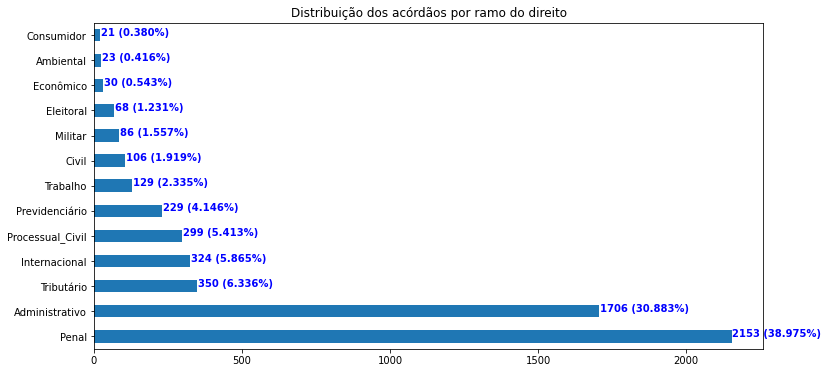

In [24]:
fig, ax = plt.subplots(figsize=(12, 6)) 

total_documents = data.shape[0]

for index, frequency in enumerate(data["ramo"].value_counts()):
    percentage = frequency / total_documents * 100
    display_value = "{frequency} ({:.3f}%)".format(percentage, frequency=frequency)
    ax.text(frequency + 3, index, display_value, color='blue', fontweight='bold')

plt.title(label='Distribuição dos acórdãos por ramo do direito', fontweight=10)
data["ramo"].value_counts().plot.barh()

A imagem acima nos mostra que a distribuição dos acórdãos entre os ramos de direito é bastante desigual. Além disso, algumas das classificações pode ser mais exigida do que outras. Por exemplo, seria mais comum exigir uma melhor performance do classificador para acórdãos do direito Penal do que do direito Internacional.

## Nível de informação presente na ementa dos acórdãos

Como o classificador terá a ementa do acórdão como principal elemento direcionador, há a necessidade de se garantir que em grande parte dos casos a ementa consegue apontar indicativos de que um acórdão pertence a um ramo do direito em específico.

Nesse caso, o atributo a ser analisado é preenchido por meio de análise humana. Assim, através de uma leitura minunciosa da ementa, especialistas procuram definir se um acórdão pode ser classificado a um ramo do direito por meio do texto da ementa.

In [9]:
data['indicacao_exclusiva_ementa_voto'].unique()

array(['Sim', 'Não', 'pagamento', 'benefício previdenciário'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


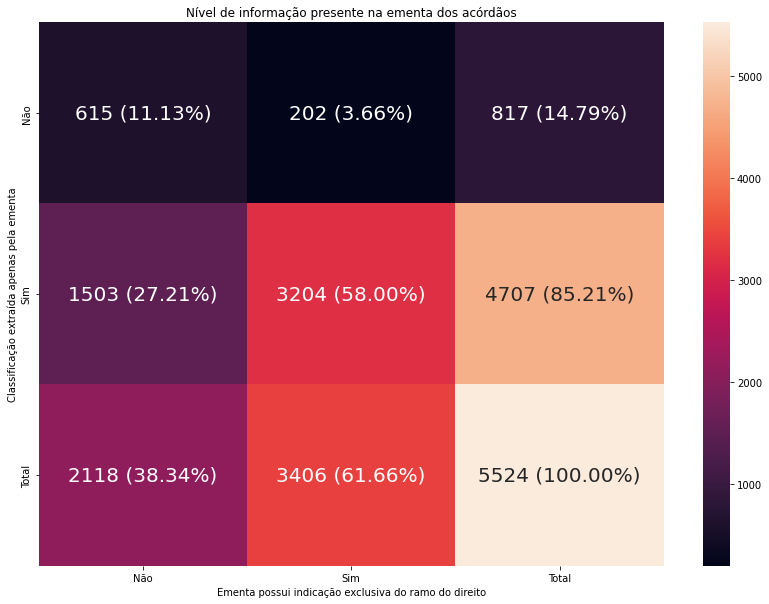

In [10]:
# The command pd.crosstab(data['somente_ementa'], data['indicacao_exculusiva_ementa'], rownames=['Actual'], colnames=['Predicted'], margins=True) also works
data2 = data.copy()

for index, row in data2.iterrows():
  if row['indicacao_exclusiva_ementa_voto'] == 'pagamento' or row['indicacao_exclusiva_ementa_voto'] == 'benefício previdenciário':
    data2['indicacao_exclusiva_ementa_voto'][index] = 'Sim'

fig, ax = plt.subplots(figsize=(14, 10)) 
crosstab = pd.crosstab(data2['somente_ementa'], data2['indicacao_exclusiva_ementa_voto'], rownames=['Classificação extraída apenas pela ementa'], colnames=['Ementa possui indicação exclusiva do ramo do direito'], margins=True)
heatmap = sns.heatmap(crosstab,
                      xticklabels=['Não', 'Sim', 'Total'], # defines the label values
                      yticklabels=['Não', 'Sim', 'Total'], # defines the label values
                      annot=True, # enable the cells to show the values
                      fmt='g', # removes the scientific notation and show integer values
                      annot_kws={"size": 20}) # setup font size

for text in heatmap.texts:
    percentage = float(text.get_text())/total_documents

    display_value = "{frequency} ({:.2f}%)".format(percentage * 100, frequency=text.get_text())
    text.set_text(display_value)

plt.title(label='Nível de informação presente na ementa dos acórdãos', fontweight=10)
plt.show()

Como esperado, em grande parte dos casos é possível extrair o ramo do direito ao qual um acórdão pertence, apenas pela análise da ementa. No gráfico acima, é possível verificar que isso ocorre em 83% dos casos. No entanto, apenas em 50% dos casos, há uma indicação exclusiva na ementa ou voto do relator que permite identificar o ramo do direito.

## Tokens essenciais para a classificação do acórdão

Para criar um modelo que sirva o propósito de classificação dos acórdãos, os dados potencialmente podem auxiliar mostrando que, para um determinado ramo do direito em específico, tem-se uma frequência maior de um grupo de termos. Isso será utilizado como premissa do modelo, de forma que ele consiga identificar esses padrões para classificar cada acórdão corretamente.

Abaixo, a análise será feita por meio dos tokens, ou seja, os termos destacados por especialistas como essenciais serão tokenizados de forma a entender como o Bert iria tratar esses termos também.

In [11]:
# Define the tokenizer using Bertimbau https://huggingface.co/neuralmind/bert-base-portuguese-cased

tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')
tokenizer

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='neuralmind/bert-large-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [12]:
def retrieve_tokens(sentence: str, tokenizer: BertTokenizer=None) -> List[str]:
    """Given a sentence with multiple words separated by ';', the function returns
    the list of tokens that it contains.
    Params:
        sentence (str): the sentence of words
    Returns:
    List[str]
        the list of tokens that represents the sentence
    """
    expressions = list(map(lambda word: word.strip(), sentence.split(';'))) # split into expressions
    expressions = list(filter(lambda expression: is_expression_valid(expression), expressions)) # filter empty strings
    expressions = list(map(lambda expression: clean_up_expression(expression), expressions))

    if tokenizer:
        return list(encode_words(expressions, tokenizer))
    return expressions

def is_expression_valid(expression: str) -> bool:
    if not expression:
        return False

    return not re.match(r'\s*\-\s*', expression)

def clean_up_expression(expression: str) -> str:
    """Given an expression, the function must return the same expression, but
    removing extra characters (e.g. blank spaces, quotation marks)
    Params:
        expression (str): the expression
    Returns:
    str
        the cleaned expression
    """
    expression = expression.strip()
    expression = expression.strip(".")
    expression = expression.strip('"').strip("“").lstrip("").rstrip("”")
    expression = expression.strip(".")
    expression = expression.strip().lower()

    return expression

def encode_words(words: List[str], tokenizer: BertTokenizer) -> List[str]:
    """Given a word, the function returns the token following BertTokenizer
    Params:
        word (List[str]): The list of words that will be encoded
    Returns:
    List[str]
        the list of tokens that represents the input words
    """
    tokens_nested_list = list(map(lambda word: tokenizer.tokenize(word), words))
    return list(chain(*tokens_nested_list))

In [13]:
# initialize the frequency counter structures
token_frequency_counter = defaultdict(int)
token_frequency_counter_by_law_branch = dict(map(lambda branch_name: (branch_name, defaultdict(int)), LawBranch.get_all_names()))

In [14]:
for _, row in data.iterrows():

    law_branch = row['ramo']
    if law_branch == 'Processual Civil':
      law_branch = 'Processual_Civil'

    for token in retrieve_tokens(row['expressoes_chave'], tokenizer=tokenizer):
        token_frequency_counter[token] += 1

        token_frequency_counter_by_law_branch[law_branch][token] += 1

pd.Series(token_frequency_counter).head()
pd.Series(token_frequency_counter_by_law_branch).head()

Penal             {'prática': 12, 'del': 29, '##itiva': 5, 'crim...
Administrativo    {'uso': 2, 'irregular': 3, 'de': 699, 'ver': 1...
Tributário        {'reclama': 1, '##tória': 1, 'trabalh': 1, '##...
Civil             {'imóvel': 2, 'rural': 1, 'proprietário': 1, '...
Previdenciário    {'tutela': 3, 'antecip': 3, '##ada': 4, 'apose...
dtype: object

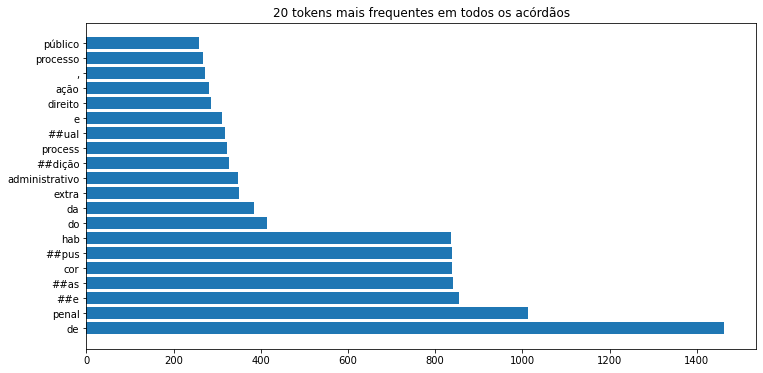

In [15]:
fig, ax = plt.subplots(figsize=(12, 6)) 

top_frequent_tokens = dict(sorted(token_frequency_counter.items(), key=itemgetter(1), reverse=True)[:CONSTANTS['NUMBER_TOP_TOKENS']])

plt.barh(list(top_frequent_tokens.keys()), top_frequent_tokens.values())
plt.title("{top_frequent_tokens_size} tokens mais frequentes em todos os acórdãos".format(top_frequent_tokens_size=CONSTANTS['NUMBER_TOP_TOKENS']))

plt.show()

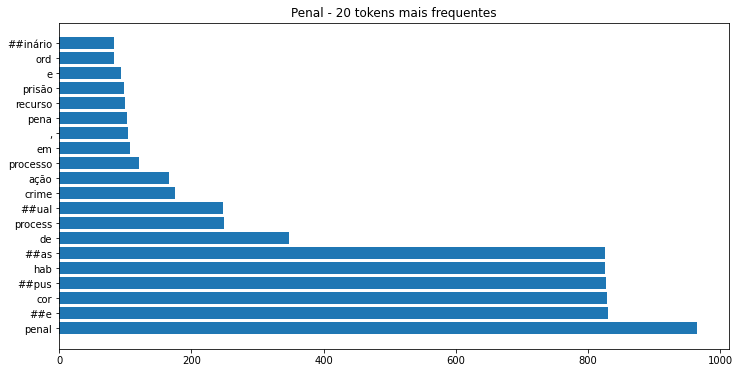

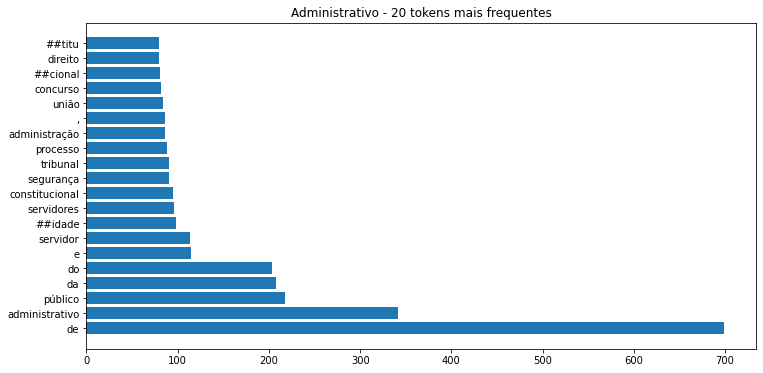

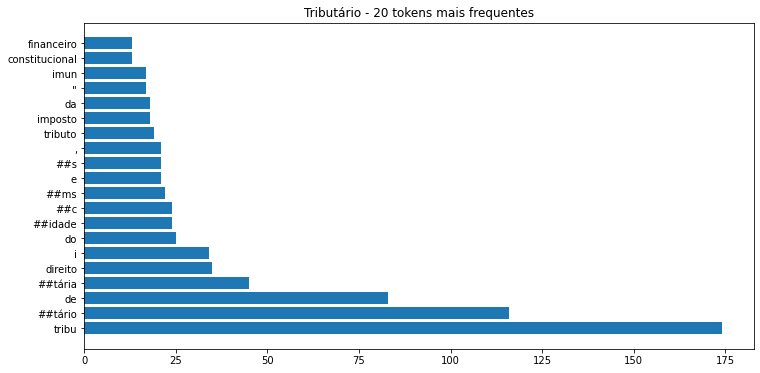

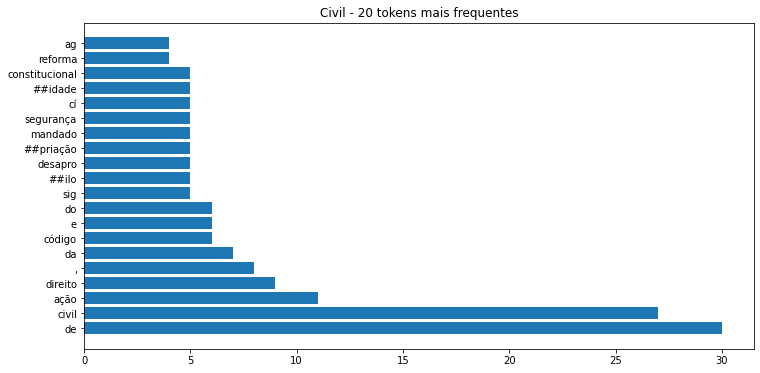

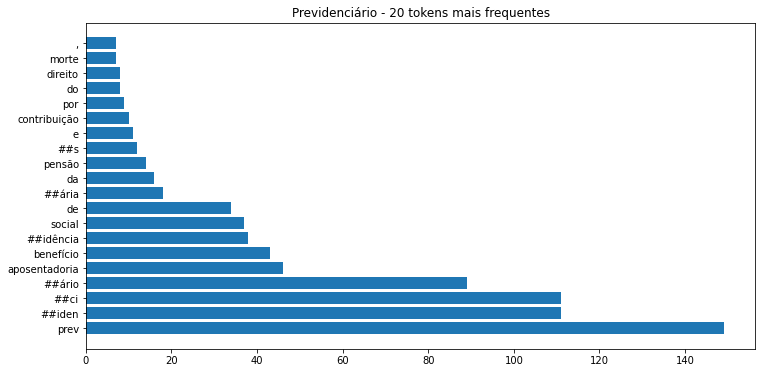

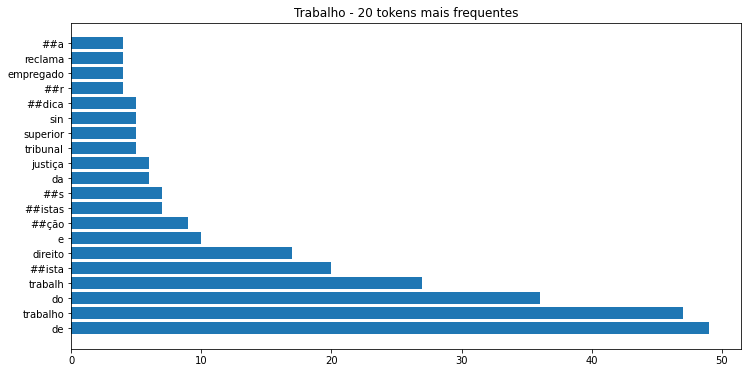

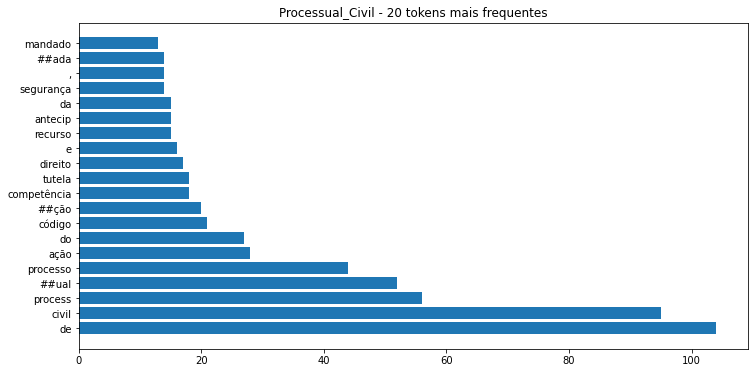

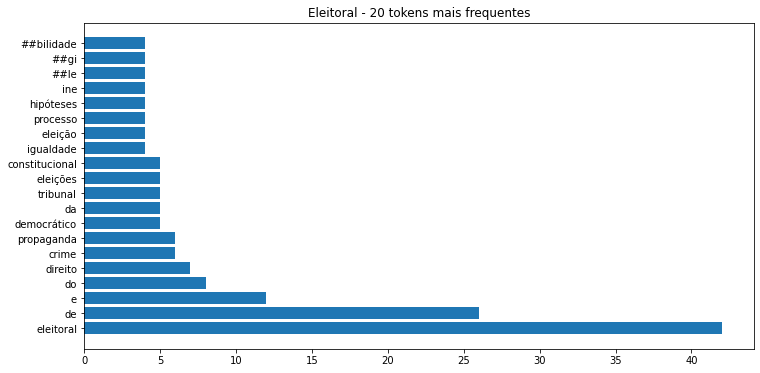

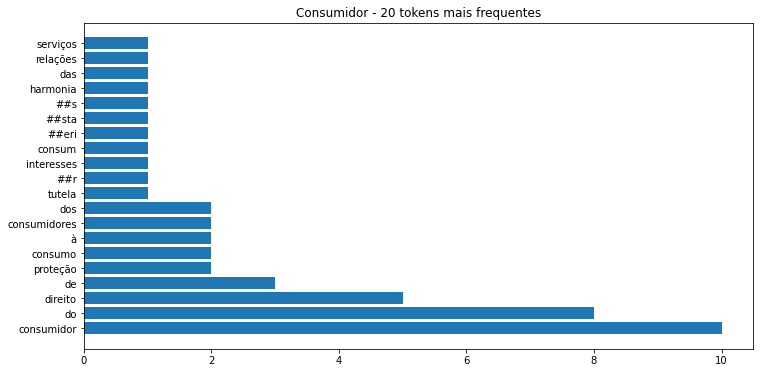

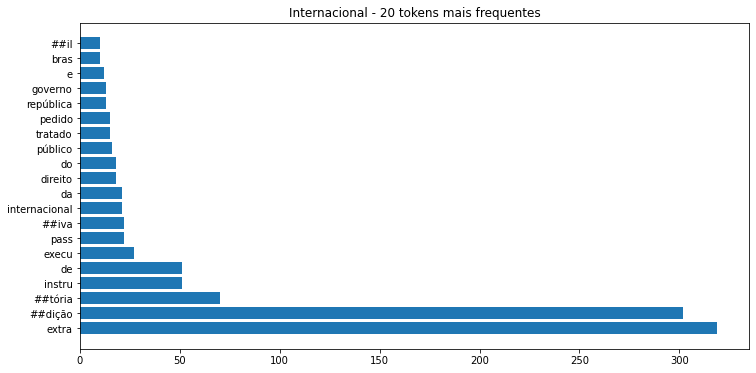

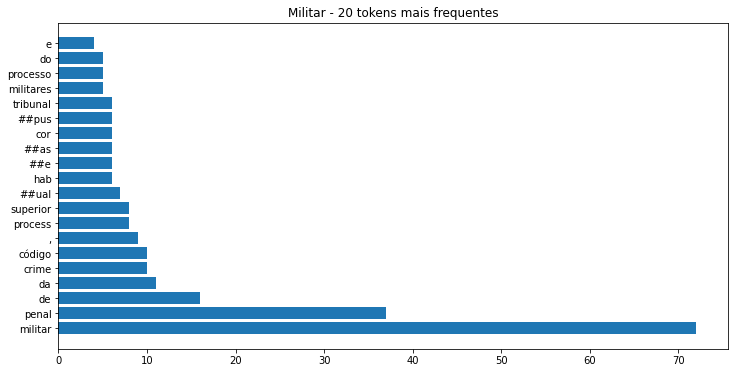

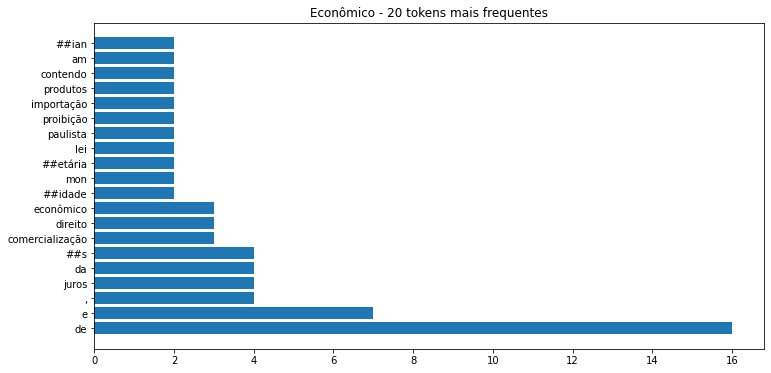

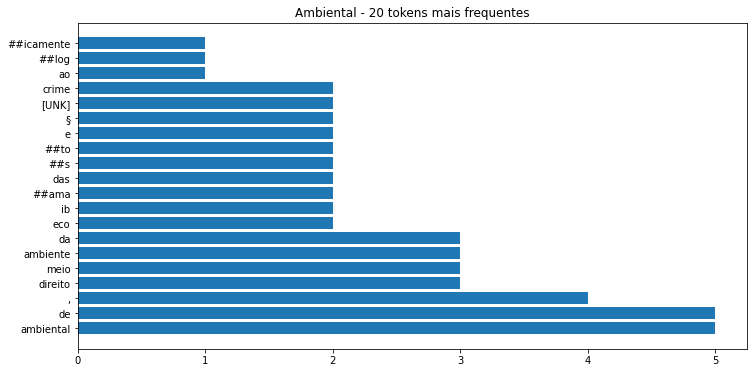

In [16]:
for law_branch in LawBranch.get_all_names():
    fig, ax = plt.subplots(figsize=(12, 6)) 

    law_branch_frequency_tokens = token_frequency_counter_by_law_branch[law_branch]

    top_frequent_tokens = dict(sorted(law_branch_frequency_tokens.items(), key=itemgetter(1), reverse=True)[:CONSTANTS['NUMBER_TOP_TOKENS']])

    plt.barh(list(top_frequent_tokens.keys()), top_frequent_tokens.values())
    plt.title("{law_branch} - {top_frequent_tokens_size} tokens mais frequentes".format(law_branch=law_branch, top_frequent_tokens_size=CONSTANTS['NUMBER_TOP_TOKENS']))

    plt.show()

    print("")

## Termos essenciais para a classificação do acórdão

Para criar um modelo que sirva o propósito de classificação dos acórdãos, os dados potencialmente podem auxiliar mostrando que, para um determinado ramo do direito em específico, tem-se uma frequência maior de um grupo de termos. Isso será utilizado como premissa do modelo, de forma que ele consiga identificar esses padrões para classificar cada acórdão corretamente.

In [17]:
# initialize the frequency counter structures
expression_frequency_counter = defaultdict(int)
expression_frequency_counter_by_law_branch = dict(map(lambda branch_name: (branch_name, defaultdict(int)), LawBranch.get_all_names()))

In [18]:
for _, row in data.iterrows():

    law_branch = row['ramo']
    if law_branch == 'Processual Civil':
      law_branch = 'Processual_Civil'

    for token in retrieve_tokens(row['expressoes_chave']):
        expression_frequency_counter[token] += 1

        expression_frequency_counter_by_law_branch[law_branch][token] += 1

print(pd.Series(expression_frequency_counter).head())
print(pd.Series(expression_frequency_counter_by_law_branch).head())

prática delitiva      1
tutela antecipada    14
imóvel rural          2
imóvel                2
proprietário          1
dtype: int64
Penal             {'prática delitiva': 1, 'crimes contra a honra...
Administrativo    {'uso irregular de verbas públicas': 1, 'suces...
Tributário        {'reclamatória trabalhista': 1, 'direito tribu...
Civil             {'imóvel rural': 1, 'imóvel': 1, 'proprietário...
Previdenciário    {'tutela antecipada': 1, 'aposentadoria': 12, ...
dtype: object


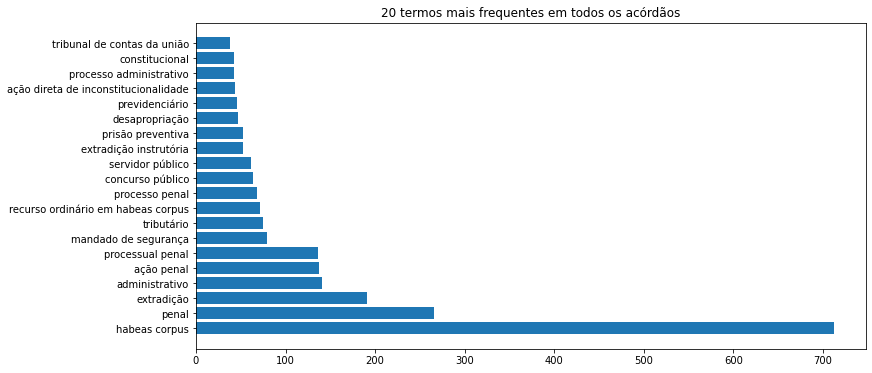

In [19]:
fig, ax = plt.subplots(figsize=(12, 6)) 

top_frequent_expressions = dict(sorted(expression_frequency_counter.items(), key=itemgetter(1), reverse=True)[:CONSTANTS['NUMBER_TOP_TOKENS']])

plt.barh(list(top_frequent_expressions.keys()), top_frequent_expressions.values())
plt.title("{top_frequent_expressions_size} termos mais frequentes em todos os acórdãos".format(top_frequent_expressions_size=CONSTANTS['NUMBER_TOP_TOKENS']))

plt.show()

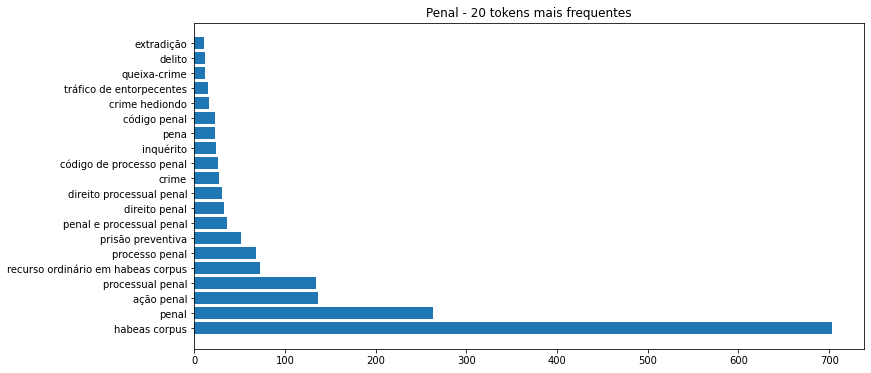

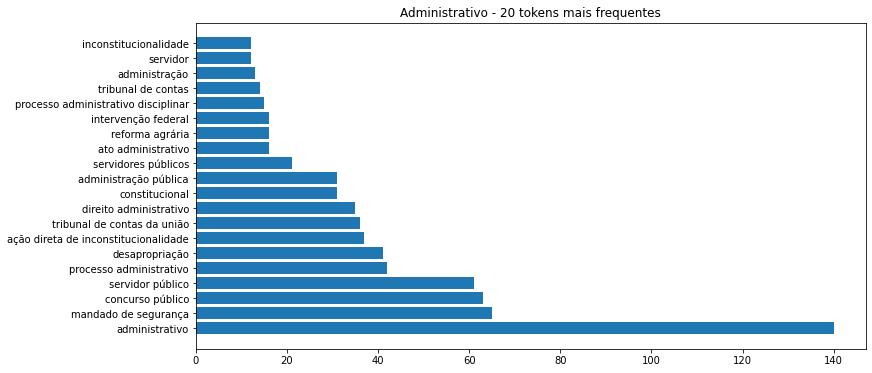

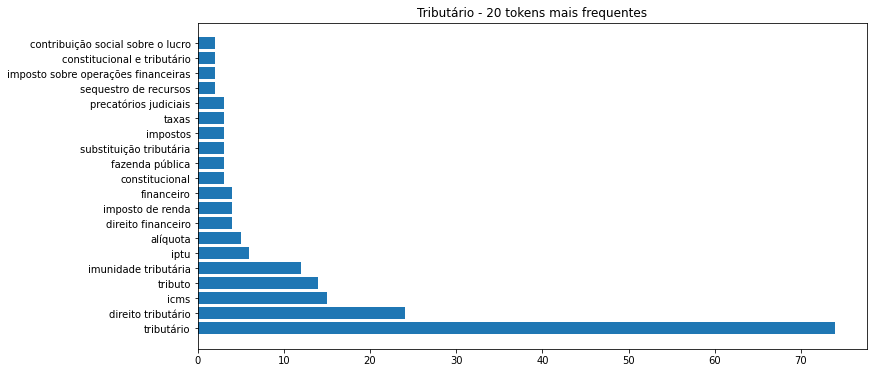

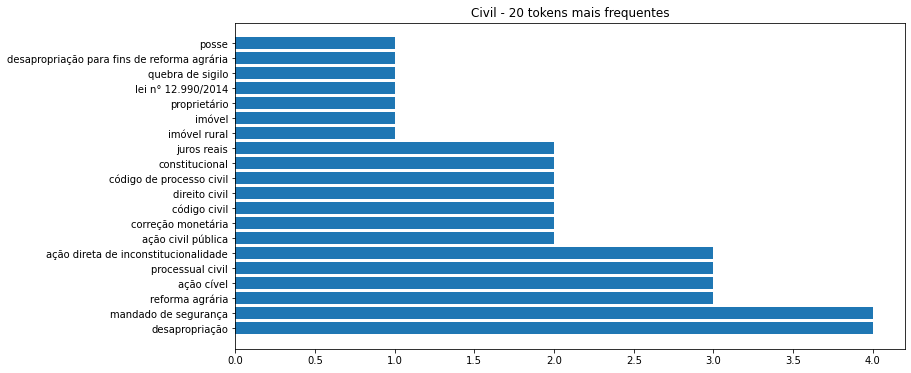

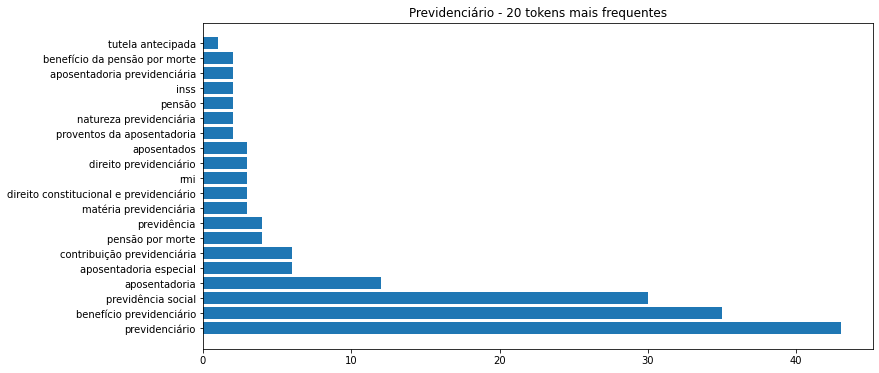

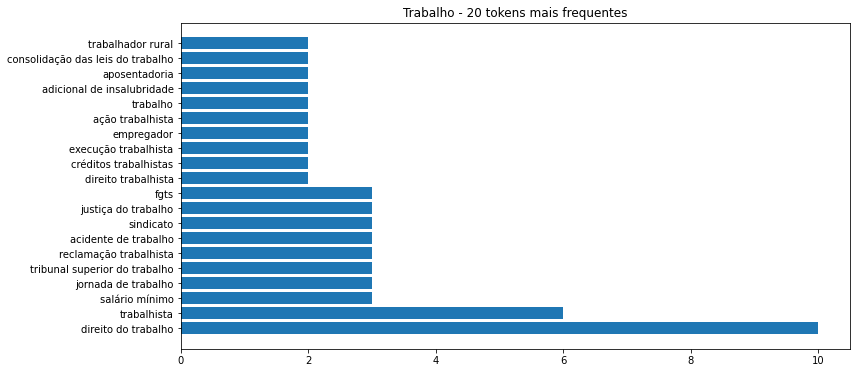

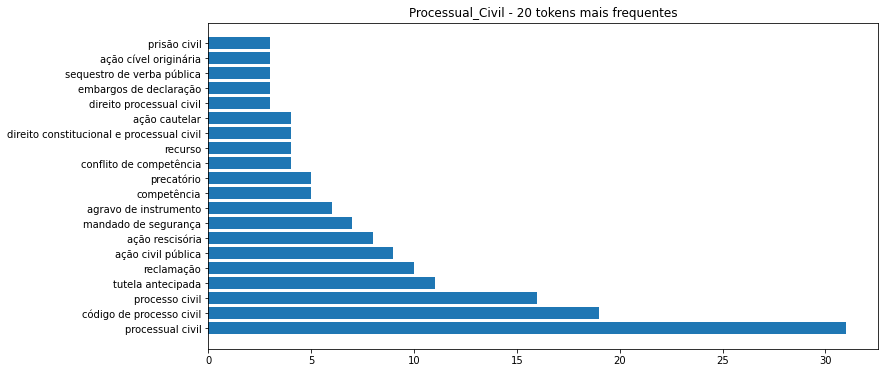

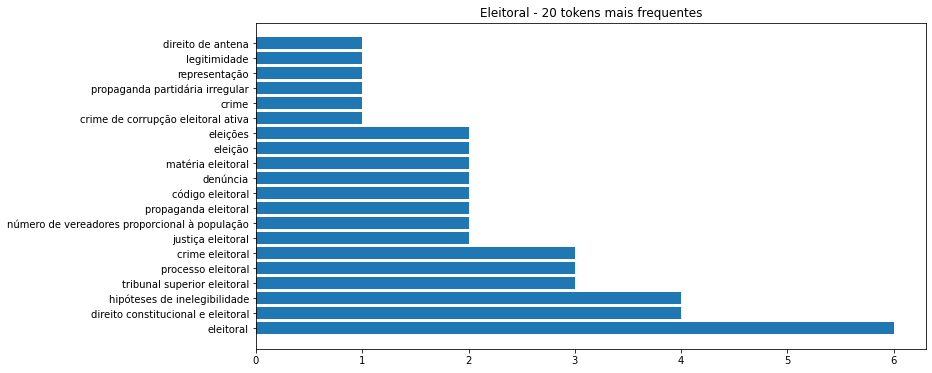

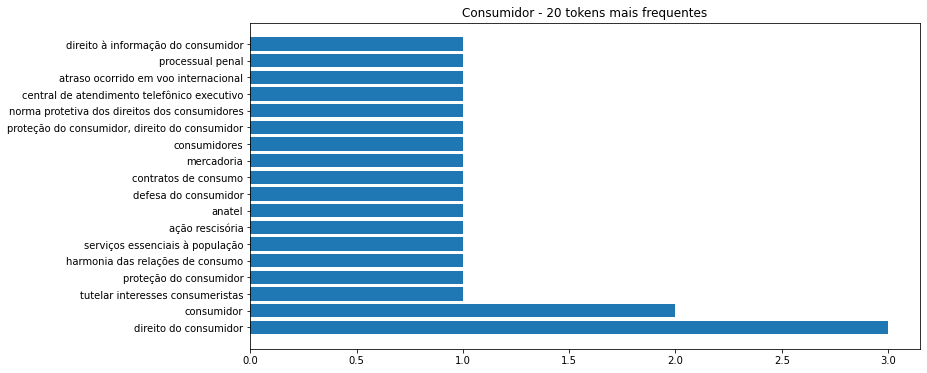

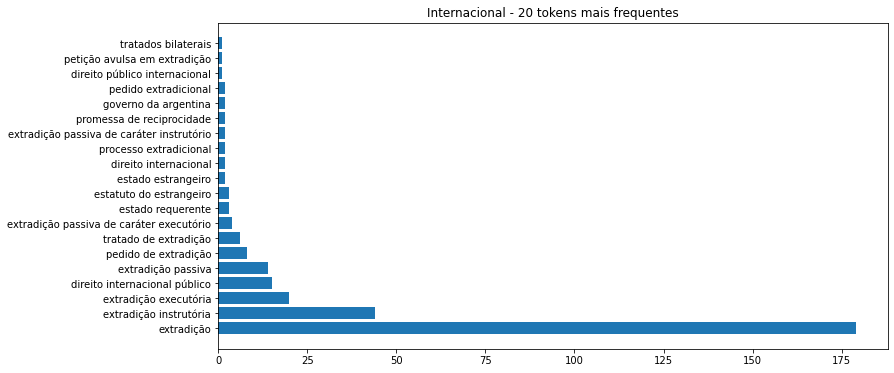

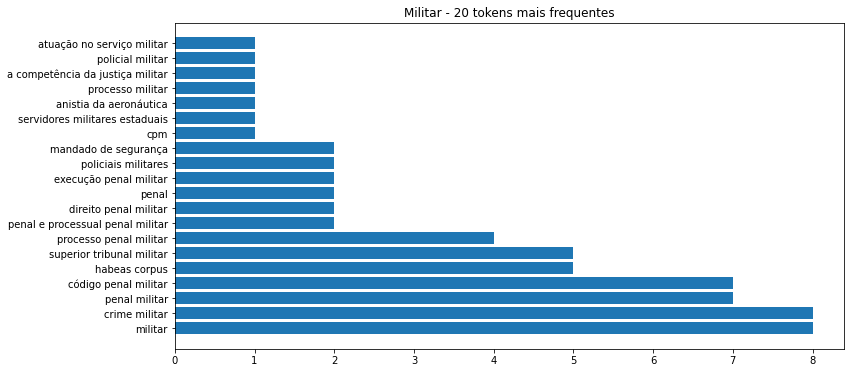

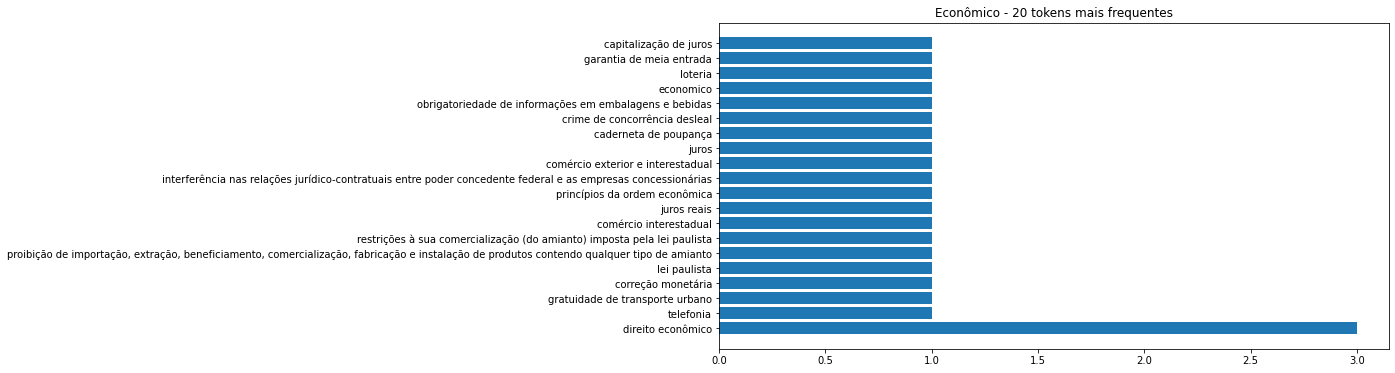

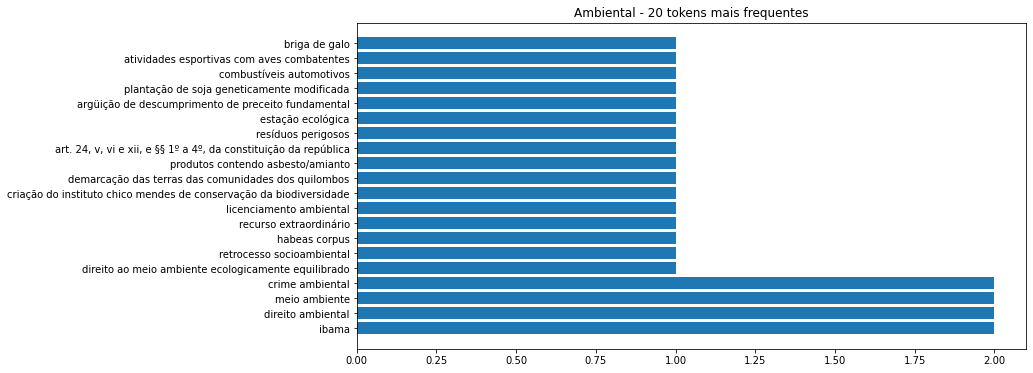

In [20]:
for law_branch in LawBranch.get_all_names():
    fig, ax = plt.subplots(figsize=(12, 6)) 

    law_branch_frequency_expressions = expression_frequency_counter_by_law_branch[law_branch]

    top_frequent_tokens = dict(sorted(law_branch_frequency_expressions.items(), key=itemgetter(1), reverse=True)[:CONSTANTS['NUMBER_TOP_TOKENS']])

    plt.barh(list(top_frequent_tokens.keys()), top_frequent_tokens.values())
    plt.title("{law_branch} - {top_frequent_tokens_size} tokens mais frequentes".format(law_branch=law_branch, top_frequent_tokens_size=CONSTANTS['NUMBER_TOP_TOKENS']))

    plt.show()

    print("")

## Termos mais comuns nas ementas dos acórdãos

Até então, os elementos analisados foram com base nos termos que os alunos de direito destacaram como importantes durante a classificação manual dos acórdãos. Dessa forma, é possível tokenizar a ementa e analisar quais os tokens mais frequentes, principalmente quando agrupandos os acórdãos por ramo do direito.

In [21]:
# initialize the frequency counter structures
token_frequency_counter_by_law_branch = dict(map(lambda branch_name: (branch_name, defaultdict(int)), LawBranch.get_all_names()))

In [22]:
for _, row in data.iterrows():

    law_branch = row['ramo']
    if law_branch == 'Processual Civil':
      law_branch = 'Processual_Civil'

    for token in retrieve_tokens(row['ementa'], tokenizer):
        token_frequency_counter_by_law_branch[law_branch][token] += 1

pd.Series(token_frequency_counter_by_law_branch).head()

Penal             {'em': 8555, '##enta': 1677, 'extra': 638, '##...
Administrativo    {'em': 4829, '##enta': 1350, ':': 2482, 'ação'...
Tributário        {'em': 1011, '##enta': 260, ':': 433, 'reclama...
Civil             {'em': 345, '##enta': 83, ':': 151, 'mandado':...
Previdenciário    {'reclama': 45, '##ção': 82, '.': 3365, 'tutel...
dtype: object

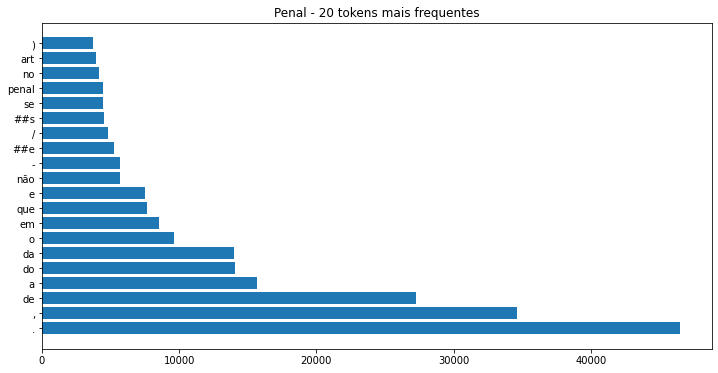

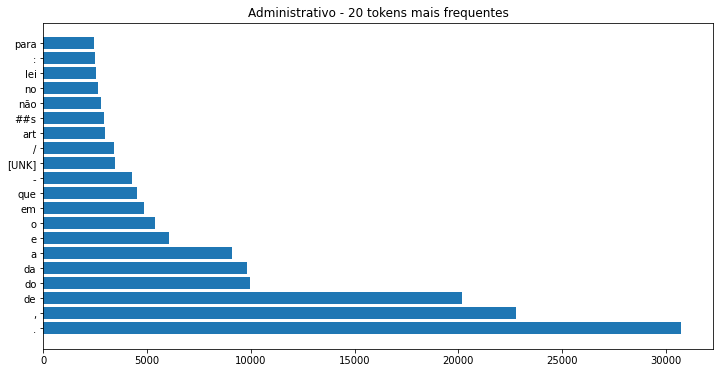

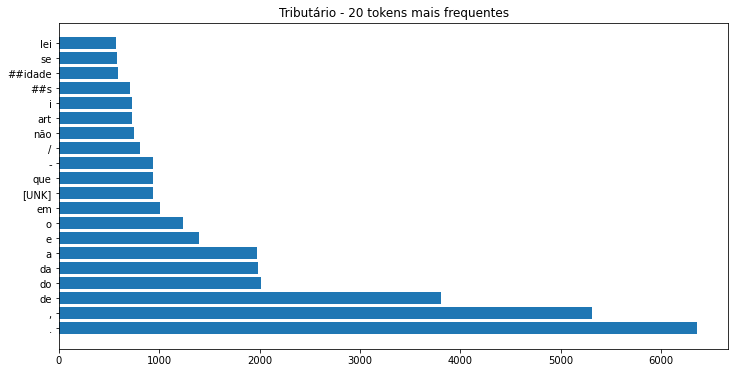

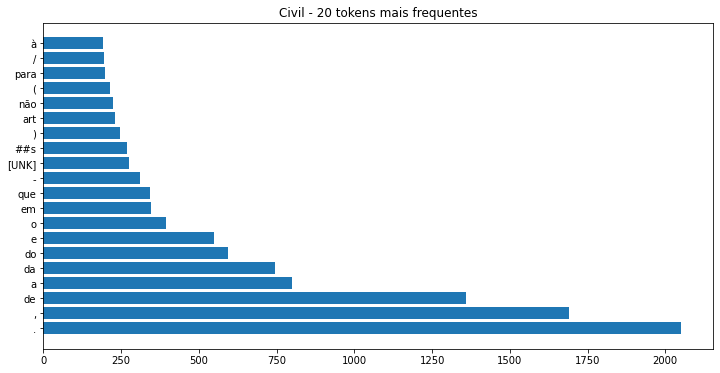

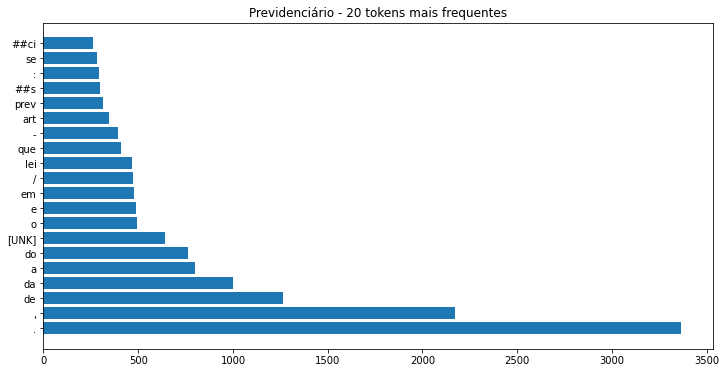

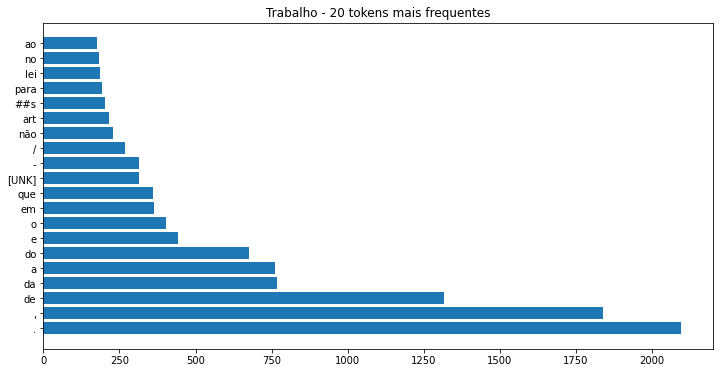

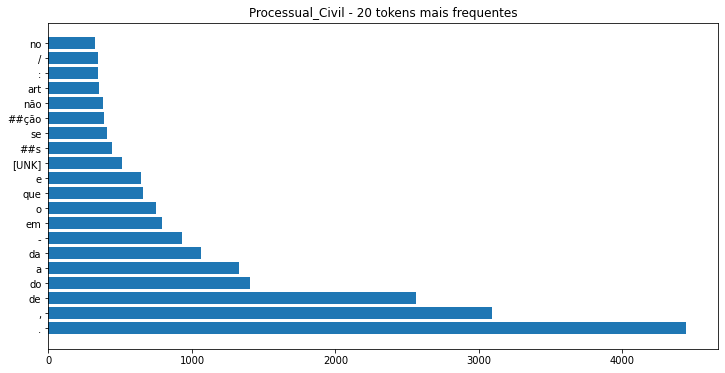

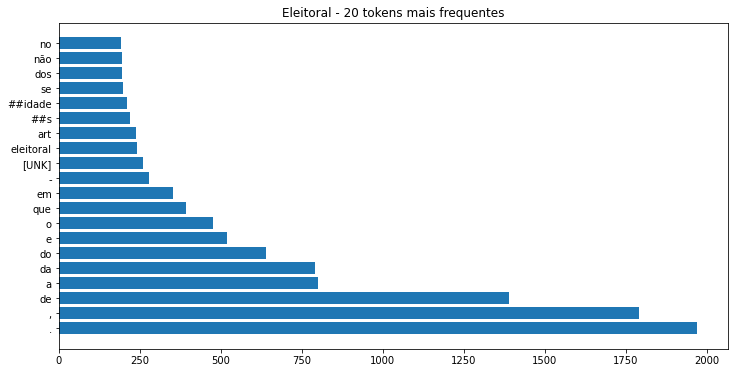

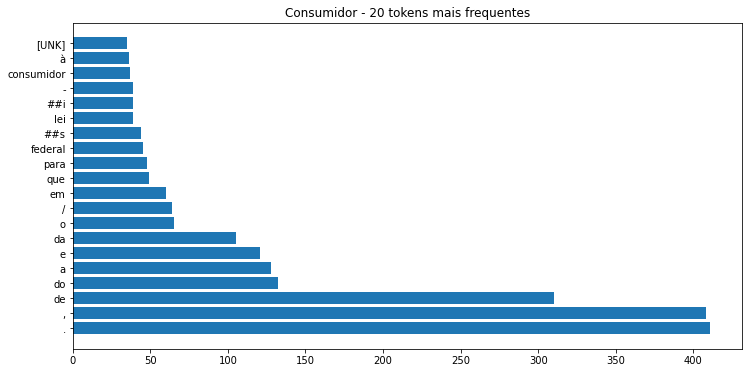

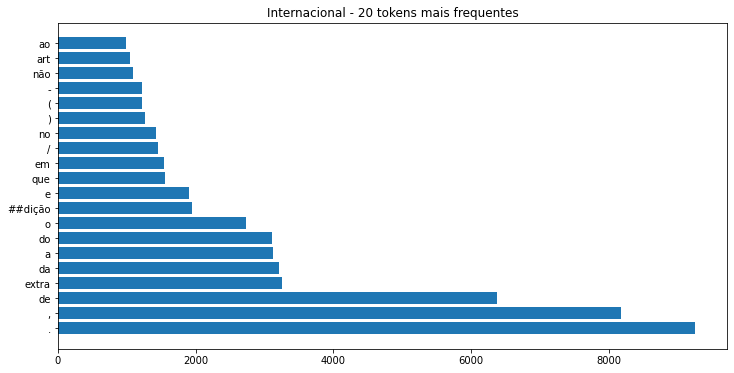

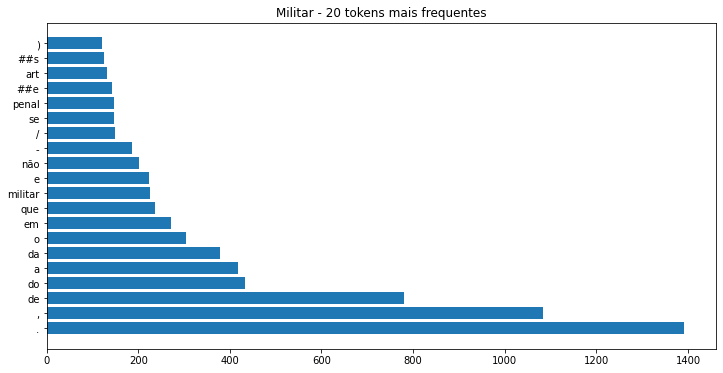

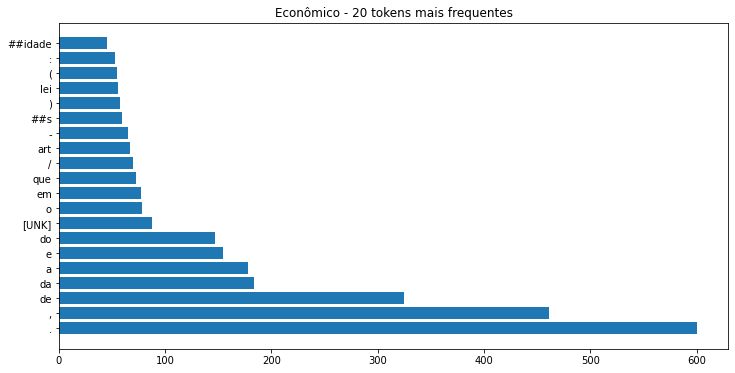

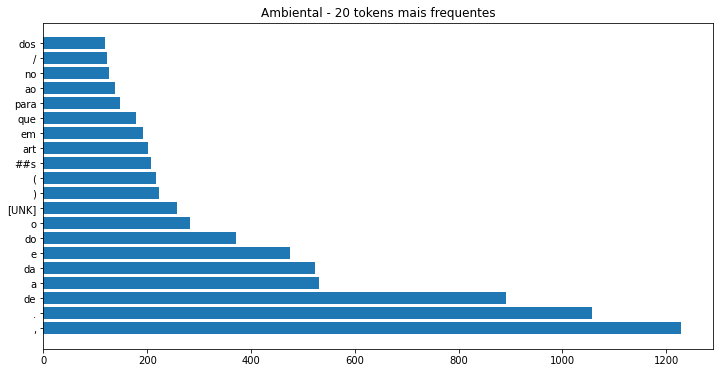

In [23]:
for law_branch in LawBranch.get_all_short_names():
    fig, ax = plt.subplots(figsize=(12, 6)) 

    law_branch_frequency_tokens = token_frequency_counter_by_law_branch[law_branch]

    top_frequent_tokens = dict(sorted(law_branch_frequency_tokens.items(), key=itemgetter(1), reverse=True)[:CONSTANTS['NUMBER_TOP_TOKENS']])

    plt.barh(list(top_frequent_tokens.keys()), top_frequent_tokens.values())
    plt.title("{law_branch} - {top_frequent_tokens_size} tokens mais frequentes".format(law_branch=law_branch, top_frequent_tokens_size=CONSTANTS['NUMBER_TOP_TOKENS']))

    plt.show()

    print("")